In [10]:
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
import statistics

c = 2.998e8 #speed of light (m/s)
h = 6.626e-34 #Planck m^2 kg/s
Pi= np.pi*1.0 #define Pi
Rsun=695700000.0  # Radius of Sun (m)
zero_point = 25.6884
tput = 0.18 
aperture = 0.15
aperture2 = 2.4
gain = 6.1 #Photons needed for a single electron event 

def changeunits(flux):
    """
    Changes the units of flux from ergs/s/cm^2/nm to watts/m^2/nm. 
    Additional scale factor is used to match GAIA magnitude values.
    """
    try:
        fluxScaled = flux * 1e-7/(0.0001)*(4*np.pi)*6.898196982008417e-19
        return fluxScaled
    except: 
        return 0
    
def numericIntegration(x,y):
    """
    Function used to numerically integrate a function.
    
    Inputs:
        x: array of the x values of the curve
        y: array of the y values of the curve
        
    Output:
        total: Value of the numeric integration.
    """
    total = 0  #Add all of the areas to this to get the final integration 
    for i in range(len(x)-1):
        width = x[i+1]-x[i]
        height = y[i] + (y[i+1]-y[i])/2
        area = width*height
        total += area
    return total


def matchlengths(flux, wavelength, fluxWavelength, Wmin = None, Wmax = None, defineRange = True):
    """
    Reduces the size of the flux array to match a specified wavelength array. 
    This also can limit the size of the wavelength array to a specific range specified.
    """
    '''
    Inputs:
        flux: flux array that will be reduced to match wavelength array. Type: array
        wavelength: Wavelength array that the length of the flux array gets matched to. Type: array
        Wmin: Minimum wavelength. Type: float
        Wmax: maximum wavelength. Type: float
        defineRange: If True the end points of the wavelength array are set to Wmin and Wmax.
                     If set to false the size of the input wavelength array is used.
    Outputs:
        VegaFlux: New flux with matching length to wavelength. Type: array
        wavelength: wavelength with new end points if specified. Type: array
    '''
    if defineRange: 
        bot = np.where(wavelength == Wmin)
        top = np.where(wavelength == Wmax)
            
        wavelength = wavelength[bot[0][0]:top[0][0]] #create new array based on the new max and min
        wavelength = np.asfarray(wavelength,float)
    
        VegaFlux = []
        VegaWavelength = []
        for i in range(len(wavelength)):
            lower, upper = 0, len(fluxWavelength)
            
            while upper - lower > 2:
                mid = lower + (upper-lower)//2
                if wavelength[i] == round(fluxWavelength[mid],2):
                    VegaFlux.append(flux[mid])
                    VegaWavelength.append(round(fluxWavelength[mid],2))
                    break
                elif wavelength[i] > round(fluxWavelength[mid],2):
                    lower = mid 
                elif wavelength[i] < round(fluxWavelength[mid],2):
                    upper = mid 
                    
        
        for i in range(len(VegaFlux)):
            VegaFlux[i] = changeunits(VegaFlux[i])
            
        VegaFlux = np.asfarray(VegaFlux, float)
        
        return VegaFlux, wavelength
    else: 
        VegaFlux = []
        VegaWavelength = []
        for i in range(len(wavelength)):
            lower, upper = 0, len(fluxWavelength)
            
            while upper - lower > 2:
                mid = lower + (upper-lower)//2
                if wavelength[i] == round(fluxWavelength[mid],2):
                    VegaFlux.append(flux[mid])
                    VegaWavelength.append(round(fluxWavelength[mid],2))
                    break
                elif wavelength[i] > round(fluxWavelength[mid],2):
                    lower = mid 
                elif wavelength[i] < round(fluxWavelength[mid],2):
                    upper = mid 
                    
        
        for i in range(len(VegaFlux)):
            VegaFlux[i] = changeunits(VegaFlux[i])
            
        VegaFlux = np.asfarray(VegaFlux, float)
        
        return VegaFlux

def Noise_calculator(starflux, wavelength, bandpass, gain, aperture, time, transit, GAIA_mag = None,
                     zero_point = None, useVEGA = True):
    """
    Generates random noise samples based on the photon count found using star flux, and GAIA magnitudes.
    
    Inputs:
        starflux: base star flux that will be scaled. Currently only VEGA flux is used, 
                  but more fluxes will be added later. Type: array
        wavelength: Wavelngth range for the bandpass. Type: array
        Bandpass: Bandpass of the filter being used. Type: float (Plan to incorporate arrays soon)
        gain: Number of photons needed for a single electron in the detector: Type: float
        aperture: Aperture size of the instrument. Type: float
        time: Time corresponding to the transit duration. Type: array
        transit: Transit function. This input will likely change in future iterations,
                 Currently used to create a function to apply noise to. Type: array
        GAIA_mag: GAIA magnitude of the desired star. Type: float
        zero_point: zero point for the GAIA magnitude. Type: float
        useVEGA: if True then vega spectrum is used to scale the flux. 
                 If False, then the flux is used without scaling.
    Outputs: 
        elecSec: The number of electrons read by the detector per second. Type: array
        countsAvg: Average number of photons read by the detector: type: float
        countsStdev: standard deviation of the counts read. Type: float
        noise: Electrons per second with added noise. Type: array
    
    """
    
    if useVEGA:
        scale = 10**((GAIA_mag-zero_point)/-2.5) #Scale the flux using GAIA magnitudes, using VEGA as the model.
        scaled_flux = starflux
        starflux = [i*scale for i in scaled_flux]
        
    middle = len(wavelength)//2
    photonCountRate = [] #create an array of the photon count over every wavelength, to be averaged over
    for i in range(len(starflux)):
        #Currently Using the box integration. Change this to be the full integration of the bandpass later.
        counts = starflux[i]*np.pi*aperture**2*(wavelength[middle]*1e-9/(h*c))*(wavelength[-1]*1e-9-wavelength[0]*1e-9)*bandpass
        photonCountRate.append(counts)
    countsAvg = statistics.mean(photonCountRate)
    countsStdev = statistics.stdev(photonCountRate)
    
    elecSec = [i*countsAvg/gain for i in transit] #Currently transit is a seperate array, will likely change later when working on 2D data
    mean_noise = 0
    noise_calc = np.random.normal(mean_noise, np.sqrt(countsStdev)*20, len(elecSec))

    noise = elecSec + noise_calc
    
    return elecSec, countsAvg, countsStdev, noise
    

In [11]:
filePath = '/home/nswidinsky/Documents/python/GAIA_mag_data'

colNames = ['Wavelength', 'Flux', 'Continuum Triplets']
VegaData200_300 = pd.read_csv(f'{filePath}/vega_flux_data_200-300.txt', delim_whitespace=True, names= colNames, header = None)
VegaData300_500 = pd.read_csv(f'{filePath}/vega_flux_data_300-500.txt', delim_whitespace=True, names= colNames, header = None)
VegaData500_1000 = pd.read_csv(f'{filePath}/vega_flux_data.txt', delim_whitespace=True, names= colNames, header = None)
VegaData1000_1400 = pd.read_csv(f'{filePath}/vega_flux_data_1000-1400.txt', delim_whitespace = True, names = colNames, header = None)

colNamesPB = ['Wavelength', 'Gmag','GmagErr','bpPb','bpPbErr','rpPb','rpPbErr']
PassBandData = pd.read_csv(f'{filePath}/GaiaDR2_RevisedPassbands.dat',delim_whitespace = True, names=colNamesPB,header=None)

GAIAtable = pd.read_csv(f'{filePath}/nexsci_ctv10planets_05282019.csv', skiprows=82)


targColNames = ['Planet Name', 'HD name','RA','DEC','Stellat Rad','Eff Temp','log(g)','st_metfe','Planet Rad','Impact Param',
                'Orb. Incl.','semi-maj axis','Orbital Period','Transit Midpoint','Transit Depth','Transit Dur.','b=acos(i)/R*',
                'GAIA mag','PRIORITY']
targetList = pd.read_csv(f'{filePath}/poetential_targets3.csv', names = targColNames, skiprows = 3)

In [12]:
##########################################################################################################################
#Change the number of points in the 500 - 1000 nm range to calculate the integral for the 500-1000nm range
##########################################################################################################################
bot, top = 500,1000
VegaFlux, wavelength= matchlengths(flux = VegaData500_1000['Flux'], wavelength = PassBandData['Wavelength'],
                                   fluxWavelength = VegaData500_1000['Wavelength'], Wmin = bot, Wmax = top)
##########################################################################################################################
#Change the number of points in the 300 - 400 nm range to calculate the integral for the 300-400nm range
##########################################################################################################################

bot, top = 300, 500  
VegaFlux300, wavelength300 = matchlengths(flux = VegaData300_500['Flux'], wavelength = PassBandData['Wavelength'], 
                                          fluxWavelength = VegaData300_500['Wavelength'], Wmin = bot, Wmax = top)
##########################################################################################################################
#Change the number of points in the 1000 - 1400 nm range to calculate the integral for the 1000-1400nm range
##########################################################################################################################
wavelength1000 = np.arange(1000, 1400, 0.25).tolist()

VegaFlux1000 = matchlengths(flux = VegaData1000_1400['Flux'], wavelength = wavelength1000, fluxWavelength = VegaData1000_1400['Wavelength'],
                            defineRange = False)

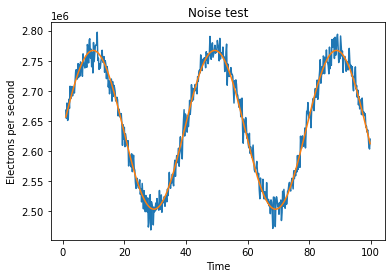

In [13]:
UbandPass = 0.20
IbandPass = 0.20
JbandPass = 0.20

############################################################################################################################################
#######       Function Call for the noise calculator function. Function uses the first magnitude in the nexsci table
############################################################################################################################################
    
time = np.arange(1,100,0.2).tolist() #Arbitrary time units to generate plot    
sinwave = []
for i in range(len(time)):
    sinwave.append(np.sin(time[i]/(2*np.pi))+20)



#### U-band 
elecSec300, counts300, countsStdev300, noise300 = Noise_calculator(starflux = VegaFlux300, wavelength = wavelength300, gain = gain, time = time,
                                                                   bandpass = 0.2, aperture = aperture, GAIA_mag = GAIAtable['gaia_gmag'][0],
                                                                   zero_point = zero_point, useVEGA = True, transit = sinwave)

#### I-band       
#test the new noise function to see if it works properly.
elecSec, counts, countsStdev, noise = Noise_calculator(starflux = VegaFlux, wavelength = wavelength, gain = gain, time = time,
                                                      bandpass = 0.2, aperture = aperture, GAIA_mag = GAIAtable['gaia_gmag'][0],
                                                      zero_point = zero_point, useVEGA = True, transit = sinwave)

### J-band
#### U-band 
elecSec1000, counts1000, countsStdev1000, noise1000 = Noise_calculator(starflux = VegaFlux1000, wavelength = wavelength1000, gain = gain, time = time,
                                                                       bandpass = 0.2, aperture = aperture, GAIA_mag = GAIAtable['gaia_gmag'][0],
                                                                       zero_point = zero_point, useVEGA = True, transit = sinwave)

    
fig = plt.figure()
plt.title('Noise test')
plt.plot(time, noise)
plt.plot(time,elecSec)
plt.xlabel('Time')
plt.ylabel('Electrons per second')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()
